# Resultados ML

In [4]:
import openpyxl,pandas as pd,numpy as np,seaborn as sns,matplotlib.pyplot as plt,mysql.connector,os,gc,shutil,sys,importlib,socket,pymysql,glob,warnings,joblib
from datetime import datetime, timedelta, date
sys.path.append('C:/Users/adrian.fernandezb/Desktop/Documentos')
import funciones
from sqlalchemy import create_engine
from getpass import *
warnings.filterwarnings('ignore')
importlib.reload(funciones)

<module 'funciones' from 'C:\\Users/adrian.fernandezb/Desktop/Documentos\\funciones.py'>

In [5]:
# orden para dataframes finales

orden_especifico_prod = ['Alta nueva movil', 'Portabilidad movil', 
                         'Alta nueva + fibra Smart','Port + fibra Smart', 'Fibra Smart',
                         'Alta nueva + fibra Neba', 'Port + fibra Neba','Fibra Neba', 
                         'Alta nueva + fibra Pro', 'Port + fibra Pro', 'Fibra Pro']

orden_especifico_can = ['06_D2D','03_STAND','01_DC',
                        '04_TELEVENTA','05_C2C','02_WEB']


# Extraccion prueba - cambio extraccion perfilado!

In [9]:
miConexion = funciones.conexionsoop(1)
miConexion2 = funciones.conexionsoop(2)
cur = miConexion.cursor()

base_resultados = 'global'
if base_resultados == 'global':
    order_general = pd.read_sql("SELECT id_order,DNI,id_client,provincia,cp,localidad,fecha_solicitud,fecha_validacion,canal,paq_pedido,paq_movil,paq_fibra,paq_fijo,port_movil,migr_movil,port_fijo,paq_celular,paq_datos,alta_movil,alta_fijo,TIPO_PAQ_FIBRA,nacionalidad,fecha_nacimiento,CANCELO_DeudaIntNok FROM order_general WHERE id_client is not null AND fecha_validacion is not null AND fecha_solicitud > '2023-01-01' AND fecha_solicitud < '2024-01-01' ",con=miConexion)
    exclusion_dni = pd.read_sql("SELECT * FROM exclusion_dni",con=miConexion)
    print('exclusion_dni_ok')
    # Quitar las pruebas
    order_general['order_general'] = np.where(order_general['DNI'].isin(exclusion_dni['DNI']), 'si', 'no')
    order_general = order_general[order_general['order_general'] != 'si']
    order_general[order_general['DNI']=='44444444A']
    print('quitar_pruebas_ok')
    dev = pd.read_csv('LISTADO_DEVOLUCIONES_DEBITO_DIRECTO.csv', sep='|')
    dev = dev.groupby('id_client').agg({'client_name': 'count','value': 'sum'})
    dev.reset_index(inplace=True)
    dev.rename(columns={'client_name': 'n_facturas','value': 'deuda'}, inplace=True)
    dev['deuda'] = dev['deuda'].astype(int)
    dev['n_facturas'] = dev['n_facturas'].astype(int)
    if dev['id_client'].nunique() == dev['id_client'].count():
        print('devoluciones_ok')
    else: print('Error, revisar')

elif base_resultados == 'perfilado': 
    perfilado_hoy = pd.read_excel('W:/Scoring/Perfilado/Resultados/Perfilado_actualizado_'+'20240412'+'.xlsx')  
    orders = tuple(perfilado_hoy['id_order'].unique())
    del perfilado_hoy

    order_general = pd.read_sql(f"SELECT id_order,DNI,id_client,provincia,cp,localidad,fecha_solicitud,fecha_validacion,canal,paq_pedido,paq_movil,paq_fibra,paq_fijo,port_movil,migr_movil,port_fijo,paq_celular,paq_datos,alta_movil,alta_fijo,TIPO_PAQ_FIBRA,nacionalidad,fecha_nacimiento,CANCELO_DeudaIntNok FROM order_general WHERE id_order IN {orders}",con=miConexion)
    exclusion_dni = pd.read_sql("SELECT * FROM exclusion_dni",con=miConexion)
    print('exclusion_dni_ok')
    # Quitar las pruebas
    order_general['order_general'] = np.where(order_general['DNI'].isin(exclusion_dni['DNI']), 'si', 'no')
    order_general = order_general[order_general['order_general'] != 'si']
    order_general[order_general['DNI']=='44444444A']
    print('quitar_pruebas_ok')
    dev = pd.read_csv('LISTADO_DEVOLUCIONES_DEBITO_DIRECTO.csv', sep='|')
    dev = dev.groupby('id_client').agg({'client_name': 'count','value': 'sum'})
    dev.reset_index(inplace=True)
    dev.rename(columns={'client_name': 'n_facturas','value': 'deuda'}, inplace=True)
    dev['deuda'] = dev['deuda'].astype(int)
    dev['n_facturas'] = dev['n_facturas'].astype(int)
    if dev['id_client'].nunique() == dev['id_client'].count():
        print('devoluciones_ok')
    else: print('Error, revisar')
else: print('Elige una base de datos')


exclusion_dni_ok
quitar_pruebas_ok
devoluciones_ok


In [10]:
# 4.- Obtener las columna de 'estado_solicitud'
miConexion = funciones.conexionsoop(1)
miConexion2 = funciones.conexionsoop(2)
order_estados = pd.read_sql("SELECT id_order, estado as estado_solicitud FROM order_estados",con=miConexion)
print('order_estados_ok')

shr = pd.read_csv('SCORING_HISTORY_REPORT_20240301.csv', sep='|')
# Aquellos con dos resultados distintos en la llamada
ff = shr.groupby('client_document').agg({'scoring': 'nunique'})
shr[shr['client_document'].isin(ff[ff['scoring'] == 2].index)].head()
shr_deudor = shr[shr['scoring'] == 0]
shr_deudor.drop_duplicates(subset='client_document', inplace=True)
shr_deudor['CANCELO_DeudaExtNok'] = 1
order_general['DNI']=order_general['DNI'].astype(str)
shr_deudor['client_document']=shr_deudor['client_document'].astype(str)
print(order_general.shape)
order_general = pd.merge(order_general, shr_deudor[['client_document','CANCELO_DeudaExtNok']], how='left', left_on='DNI', right_on='client_document')
order_general['CANCELO_DeudaExtNok'].fillna(0, inplace=True)
order_general.drop(columns=['client_document'], inplace=True)
print(order_general.shape)

order_estados_ok
(1363657, 25)
(1363657, 26)


In [11]:
join = pd.merge(order_general
                   , dev
                   , how='left'
                   , left_on = 'id_client'
                   , right_on = 'id_client')
print(join.shape)
del order_general, dev
join_1 = join[['id_order','DNI','id_client','provincia','cp','localidad',
                 'fecha_solicitud','fecha_validacion','canal','paq_pedido','paq_movil',
                 'paq_fibra','paq_fijo','port_movil','migr_movil','port_fijo',
                 'paq_celular','paq_datos','alta_movil','alta_fijo',
                 'TIPO_PAQ_FIBRA','nacionalidad','fecha_nacimiento',
                 'CANCELO_DeudaExtNok', # si pone 1 es que tiene deuda externa
                 'CANCELO_DeudaIntNok', # si pone 1 es que tiene deuda interna
                 'deuda','n_facturas'
              ]]
del join
order_estados['id_order']=order_estados['id_order'].astype(int).astype(str)
join_1['id_order']=join_1['id_order'].astype(int).astype(str)
join_2 = pd.merge(join_1, order_estados, how='left', on = 'id_order')
del join_1, order_estados
print(join_2.shape)

(1363657, 28)
(1363657, 28)


In [12]:
# 5.-Creamos una columna con el tipo de fibra (dividiendo el tipo de fibra entre SMART NEBA Y PRO-DIGI)
conditionlist = [
    (join_2['TIPO_PAQ_FIBRA'] == 'Fibra SMART 1Gb') | (join_2['TIPO_PAQ_FIBRA'] == 'Fibra SMART 500Mb'),
    (join_2['TIPO_PAQ_FIBRA'] == 'Fibra 1Gb') | (join_2['TIPO_PAQ_FIBRA'] == 'Fibra 300Mb') | (join_2['TIPO_PAQ_FIBRA'] == 'Fibra DIGI'),
    (join_2['TIPO_PAQ_FIBRA'] == 'Fibra PRO-DIGI 10 Gb')]
choicelist = ['SMART', 'NEBA', 'PRO-DIGI']
join_2['Paquete_Fibra'] = np.select(conditionlist, choicelist, default='Not Specified')
del conditionlist, choicelist
# 6.- Crear la columna de EDAD y calcular la columna 'tipo_documento'
join_2['fecha_nacimiento'] = pd.to_datetime(join_2['fecha_nacimiento'])
# join_2['edad_client'] = (datetime.now() - join_2['fecha_nacimiento']).dt.days#.astype('<m8[Y]')
join_2['edad_client'] = (datetime.today().year - join_2['fecha_nacimiento'].dt.year).astype('int')
print('EDAD_ok')
join_2['tipo_documento'] = np.where(join_2['DNI'].str[0].str.isalpha(), 'NIE', 'DNI')
print('tipo_documento_ok')
muestra = join_2[['TIPO_PAQ_FIBRA','id_order',
                 'DNI',
                 'id_client',
                 'provincia','cp',
                 'estado_solicitud',
                 'fecha_solicitud',
                 'fecha_validacion',
                 'canal',
                 'CANCELO_DeudaExtNok',
                 'CANCELO_DeudaIntNok',
                 'deuda',
                 'n_facturas',                 
                 'edad_client',                 
                 'nacionalidad',
                 'tipo_documento',                 
                 'port_movil','alta_movil','paq_movil','paq_fibra','paq_fijo','Paquete_Fibra']]
# Calcular la media sin atipicos
media = muestra[(muestra['edad_client'] <= 105) & (muestra['edad_client'] >= 18)]['edad_client'].mean()
# Sustituir atipicos por la media
muestra.loc[muestra['edad_client'] > 105, 'edad_client'] = media
muestra.loc[muestra['edad_client'] < 18, 'edad_client'] = media
## Eliminamos las columnas que no necesitamos
try:
    df = muestra.drop(columns=(['Unnamed: 0']), axis=1)
except:
    df = muestra.copy()
del muestra
## Para rellenar los NaNs de una columna
df['deuda'] = df['deuda'].fillna(0)
df['n_facturas'] = df['n_facturas'].fillna(0)
# Renombramos la columna DNI a Numero_DNI
df.rename(columns={'DNI': 'Numero_DNI'}, inplace=True)
print(df.shape)

EDAD_ok
tipo_documento_ok
(1363657, 23)


# Archivo seguridad

----------------

In [6]:
# Archivo anterior!:
quitar_yaclientes_scoringinterno_solo1order = False
if quitar_yaclientes_scoringinterno_solo1order == True:
    df = pd.read_csv('df_resultados_prueba2.csv', sep='|')
    primera_solicitud = pd.read_csv('V:/01_Scoring/BBDD/Actual/primera_solicitud.csv')
    print(df.shape)
    df['id_order']=df['id_order'].astype(str)
    primera_solicitud['id_order']=primera_solicitud['id_order'].astype(str)
    primera_solicitud = primera_solicitud[['id_order']]
    df = pd.merge(df, primera_solicitud, how='inner', on='id_order')
    print(df.shape)
    print('SOLO PRIMERA SOLICITUD')
    del primera_solicitud
else:    
    df = pd.read_csv('df_resultados_prueba2.csv', sep='|')
    print('TODAS LAS SOLICITUDES')

TODAS LAS SOLICITUDES


# Adaptacion BBDD

In [8]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(df)

,TIPO_PAQ_FIBRA,id_order,Numero_DNI,id_client,provincia,cp,estado_solicitud,fecha_solicitud,fecha_validacion,canal,CANCELO_DeudaExtNok,CANCELO_DeudaIntNok,deuda,n_facturas,edad_client,nacionalidad,tipo_documento,port_movil,alta_movil,paq_movil,paq_fibra,paq_fijo,Paquete_Fibra
0,0,56171,35541600E,11228345.0,Madrid,28108,Validated,2023-02-06 12:38:01,2023-02-06 12:58:46,02_WEB,0.0,0,0.0,0.0,38.0,ESPAÑA,DNI,0,2,2,0,0,Not Specified
1,Fibra 1Gb,18679696,Y8961428K,11311086.0,Alicante/Alacant,3003,Validated,2023-02-06 09:40:00,2023-02-22 09:39:20,02_WEB,0.0,0,0.0,0.0,69.0,FRANCIA,NIE,0,0,0,1,0,NEBA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363655,Fibra 1Gb,18673978,49001792Q,11236319.0,Madrid,28991,Validated,2023-02-05 23:56:24,2023-02-07 15:55:25,02_WEB,0.0,0,0.0,0.0,39.0,ESPAÑA,DNI,3,0,3,1,1,NEBA
1363656,Fibra SMART 1Gb,18674021,46987607X,11234442.0,Barcelona,8038,Validated,2023-02-05 23:57:59,2023-02-07 11:52:49,02_WEB,0.0,0,0.0,0.0,34.0,ESPAÑA,DNI,2,0,2,1,0,SMART


## Eleccion logica perfilado

In [10]:
# Ordenamos el dataframe por DNI y fecha de validación
df.sort_values(['Numero_DNI', 'fecha_validacion'], inplace=True)

# Rellenamos los valores nulos en 'fecha_validacion' con un valor futuro
df['fecha_validacion'].fillna(pd.Timestamp('2100-01-01'), inplace=True)

# Creamos la columna 'fecha_definitiva'
df['fecha_perfilado'] = df.groupby('Numero_DNI').apply(lambda x: x['fecha_solicitud'].where(x['fecha_validacion'].shift() < x['fecha_solicitud'], x['fecha_validacion'])).reset_index(level=0, drop=True)

# Reemplazamos los valores futuros por NaN
df['fecha_perfilado'].replace(pd.Timestamp('2100-01-01'), np.nan, inplace=True)


In [21]:
df[df['Numero_DNI']==' 09906993L']

,TIPO_PAQ_FIBRA,id_order,Numero_DNI,id_client,provincia,cp,estado_solicitud,fecha_solicitud,fecha_validacion,canal,...,edad_client,nacionalidad,tipo_documento,port_movil,alta_movil,paq_movil,paq_fibra,paq_fijo,Paquete_Fibra,fecha_perfilado
783462,0,25992932,09906993L,8009569.0,Zaragoza,50780,Validated,2023-09-06 18:27:54,2023-09-07 06:14:10,04_TELEVENTA,...,29.0,ESPAÑA,DNI,1,0,1,0,0,Not Specified,2023-09-07 06:14:10


In [23]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
    display(df)

,TIPO_PAQ_FIBRA,id_order,Numero_DNI,id_client,provincia,cp,estado_solicitud,fecha_solicitud,fecha_validacion,canal,CANCELO_DeudaExtNok,CANCELO_DeudaIntNok,deuda,n_facturas,edad_client,nacionalidad,tipo_documento,port_movil,alta_movil,paq_movil,paq_fibra,paq_fijo,Paquete_Fibra,fecha_perfilado
833795,0,26355908,04746959N,6707351.0,Madrid,28944,Validated,2023-09-17 19:35:49,2023-09-18 12:29:37,03_STAND,0.0,0,0.0,0.0,39.000000,ESPAÑA,DNI,1,0,1,0,0,Not Specified,2023-09-18 12:29:37
783462,0,25992932,09906993L,8009569.0,Zaragoza,50780,Validated,2023-09-06 18:27:54,2023-09-07 06:14:10,04_TELEVENTA,0.0,0,0.0,0.0,29.000000,ESPAÑA,DNI,1,0,1,0,0,Not Specified,2023-09-07 06:14:10
1078894,0,28213069,12796276L,10410787.0,Madrid,28701,Validated,2023-11-15 18:27:26,2023-11-15 19:57:09,03_STAND,0.0,0,0.0,0.0,35.000000,ESPAÑA,DNI,0,1,1,0,0,Not Specified,2023-11-15 19:57:09
253578,0,20867634,13324147V,9802611.0,Alicante/Alacant,3013,Validated,2023-04-17 10:57:04,2023-04-18 11:50:29,04_TELEVENTA,0.0,0,0.0,0.0,52.000000,ESPAÑA,DNI,0,1,1,0,0,Not Specified,2023-04-18 11:50:29
520079,0,23296237,13343041M,6352601.0,Ávila,5002,Validated,2023-06-26 19:42:20,2023-06-27 06:27:22,02_WEB,0.0,0,0.0,0.0,27.000000,ESPAÑA,DNI,0,1,1,0,0,Not Specified,2023-06-27 06:27:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581554,0,23920116,y8542470p,11502766.0,Barcelona,8006,Validated,2023-07-12 13:44:02,2023-07-19 16:41:23,01_DC,0.0,0,0.0,0.0,45.752995,ESPAÑA,NIE,0,3,3,0,0,Not Specified,2023-07-19 16:41:23
581555,0,23920120,y8542470p,11502766.0,Barcelona,8006,Validated,2023-07-12 13:44:04,2023-07-19 16:42:54,01_DC,0.0,0,0.0,0.0,45.752995,ESPAÑA,NIE,0,3,3,0,0,Not Specified,2023-07-19 16:42:54
581610,0,23920658,y8542470p,11502784.0,Barcelona,8006,Validated,2023-07-12 13:52:51,2023-07-19 16:43:06,01_DC,0.0,0,0.0,0.0,45.752995,ESPAÑA,NIE,0,1,1,0,0,Not Specified,2023-07-19 16:43:06
337206,0,21760522,y8542470p,11502766.0,Barcelona,8006,Validated,2023-05-09 16:21:11,2023-05-23 18:54:43,01_DC,0.0,0,0.0,0.0,45.752995,ESPAÑA,NIE,0,1,1,0,0,Not Specified,2023-05-23 18:54:43


## Huella y deudor

In [ ]:
vec=np.vectorize(funciones.paquetes)
df['TIPO_PEDIDO'] = vec(df['paq_movil'], df['paq_fibra'],df['paq_fijo'])
huella = lambda row: funciones.encontrar_huella(row['port_movil'],row['alta_movil'],row['TIPO_PAQ_FIBRA'])
df['HUELLA_INTERMEDIO'] = df.apply(huella, axis=1)
df['HUELLA']=df['TIPO_PEDIDO']+'_'+df['HUELLA_INTERMEDIO']

df['deuda'] = df['deuda'].fillna(0)
df['n_facturas'] = df['n_facturas'].fillna(0)
df.deuda = df.deuda.astype(int)
df['deudor'] = df.apply(lambda row: 1 if row['deuda'] >= 2 else 0, axis=1)
df.deudor = df.deudor.astype(int)
try: df.drop(columns=['Unnamed: 0'],inplace=True)
except: pass
df1 = df.copy()

## Separacion X e Y

In [5]:
y = df['deudor'].values
X = df.drop(['TIPO_PAQ_FIBRA','id_order','Numero_DNI','id_client','fecha_solicitud','estado_solicitud','fecha_validacion','deudor','n_facturas','deuda','cp'], axis = 1)
for df in [X]:
    for i in list(df['canal'].unique()):
        df[i]=np.where(df['canal']==i,1,0)
    
    for i in list(df['tipo_documento'].unique()):
        df[i]=np.where(df['tipo_documento']==i,1,0)
        
    for i in list(df['Paquete_Fibra'].unique()):
        df[i]=np.where(df['Paquete_Fibra']==i,1,0)
        
    for i in list(df['provincia'].unique()):
        df[i]=np.where(df['provincia']==i,1,0)  
    df.drop(columns=(['canal','tipo_documento','Paquete_Fibra','provincia']), axis=1, inplace=True)
    umbral_nacionalidad = 1
    nacionalidades = list(((df['nacionalidad'].value_counts(normalize=True)*100) > umbral_nacionalidad).index)
    df['count'] = df.groupby('nacionalidad')['nacionalidad'].transform('count') / df.shape[0] * 100
    df['nacionalidad_new'] = np.where(df['count']>0.25, df['nacionalidad'], 'RESTO DEL MUNDO')
    for i in list(df['nacionalidad_new'].unique()):
        df[i]=np.where(df['nacionalidad_new']==i,1,0) 
    df.drop(columns=['nacionalidad_new','nacionalidad','count'], inplace=True)
    try: 
        df.drop(columns=(['count','nacionalidad_new']), axis=1, inplace=True)
    except: pass


try: X.drop(['Unnamed: 0'], axis = 1, inplace=True)
except: pass
try: X.drop(['Huella'], axis = 1, inplace=True)
except: pass
for col in ['Renta_neta_persona','Renta_neta_hogar_prov','Renta_neta_hogar','Renta_neta_persona_prov']:
    try: 
        X.drop([col], axis = 1, inplace=True)
    except:pass

# Huella

huella_dummies = pd.get_dummies(X['HUELLA'])
X = pd.concat([X, huella_dummies], axis=1)
for c in ['01_MOVIL_Alta_nueva', '01_MOVIL_Portabilidad', '02_MOV+FIBRA_Alta_nueva', '02_MOV+FIBRA_Alta_nueva_+_Neba', '02_MOV+FIBRA_Alta_nueva_+_Propia', '02_MOV+FIBRA_Portabilidad', '02_MOV+FIBRA_Portabilidad_+_Neba', '02_MOV+FIBRA_Portabilidad_+_Propia', '03_MOV+FIJO+FIBRA_Alta_nueva_+_Neba', '03_MOV+FIJO+FIBRA_Alta_nueva_+_Propia', '03_MOV+FIJO+FIBRA_Portabilidad_+_Neba', '03_MOV+FIJO+FIBRA_Portabilidad_+_Propia', '04_FIBRA_Neba', '04_FIBRA_Propia', '05_FIBRA+FIJO_Neba', '05_FIBRA+FIJO_Propia']:
    try:
        X[c] = X[c] * 1
    except:pass
X = X.drop(['HUELLA'], axis = 1)

In [6]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(X)

,CANCELO_DeudaExtNok,CANCELO_DeudaIntNok,edad_client,port_movil,alta_movil,paq_movil,paq_fibra,paq_fijo,TIPO_PEDIDO,HUELLA_INTERMEDIO,02_WEB,04_TELEVENTA,05_C2C,03_STAND,06_D2D,01_DC,07_TIENDA_DIGI,DNI,NIE,Not Specified,NEBA,SMART,PRO-DIGI,Madrid,Alicante/Alacant,Sevilla,Huelva,Valencia/València,Asturias,Granada,Barcelona,Almería,Girona,Toledo,Santa Cruz de Tenerife,Zaragoza,"Rioja, La",Albacete,"Palmas, Las","Balears, Illes",Cáceres,Valladolid,Murcia,Guadalajara,Málaga,Badajoz,Ávila,Lugo,Lleida,Córdoba,Castellón/Castelló,Tarragona,Segovia,Navarra,Jaén,Salamanca,Cantabria,Bizkaia,Pontevedra,Gipuzkoa,Burgos,León,"Coruña, A",Araba/Álava,Cádiz,Ourense,Ciudad Real,Zamora,Cuenca,Huesca,Teruel,Palencia,Ceuta,Soria,Melilla,ESPAÑA,FRANCIA,RESTO DEL MUNDO,MARRUECOS,RUMANIA,COLOMBIA,UCRANIA,VENEZUELA,ARGENTINA,PERU,BRASIL,HONDURAS,CHINA,PAKISTAN,CUBA,PORTUGAL,ALEMANIA,ITALIA,RUSIA,NICARAGUA,ECUADOR,PARAGUAY,BULGARIA,01_MOVIL_Alta_nueva,01_MOVIL_Portabilidad,02_MOV+FIBRA_Alta_nueva_+_Neba,02_MOV+FIBRA_Alta_nueva_+_Propia,02_MOV+FIBRA_Portabilidad_+_Neba,02_MOV+FIBRA_Portabilidad_+_Propia,03_MOV+FIJO+FIBRA_Alta_nueva_+_Neba,03_MOV+FIJO+FIBRA_Alta_nueva_+_Propia,03_MOV+FIJO+FIBRA_Portabilidad_+_Neba,03_MOV+FIJO+FIBRA_Portabilidad_+_Propia,04_FIBRA_Neba,04_FIBRA_Propia,05_FIBRA+FIJO_Neba,05_FIBRA+FIJO_Propia
0,0.0,0,38.0,0,2,2,0,0,01_MOVIL,Alta_nueva,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0,69.0,0,0,0,1,0,04_FIBRA,Neba,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363655,0.0,0,39.0,3,0,3,1,1,03_MOV+FIJO+FIBRA,Portabilidad_+_Neba,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1363656,0.0,0,34.0,2,0,2,1,0,02_MOV+FIBRA,Portabilidad_+_Propia,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Forzar prevision sin Buro

In [8]:
forzar = 0
if forzar > 1:
    X['CANCELO_DeudaExtNok'] = 0
    print('Forzado')
else: print('No forzado')

No forzado


In [9]:
for c in ['HUELLA_INTERMEDIO', 'TIPO_PEDIDO','alta_movil','port_movil','paq_fijo','paq_fibra','paq_movil']:
    try:
        X.drop(c, axis=1,inplace=True)
    except: pass

In [10]:
from joblib import load

# Deuda interna si/no

In [11]:
col_originales = ['CANCELO_DeudaExtNok','CANCELO_DeudaIntNok', 'edad_client', '01_DC', '02_WEB', '04_TELEVENTA', '06_D2D', '05_C2C', '03_STAND', '07_TIENDA_DIGI', 'DNI', 'NIE', 'Barcelona', 'Madrid', 'Badajoz', 'Almería', 'Sevilla', 'Huelva', 'Valencia/València', 'Zaragoza', 'Santa Cruz de Tenerife', 'Málaga', 'Balears, Illes', 'Bizkaia', 'Palmas, Las', 'Cáceres', 'Córdoba', 'Cuenca', 'Navarra', 'Palencia', 'Murcia', 'Cantabria', 'Alicante/Alacant', 'Girona', 'Castellón/Castelló', 'Valladolid', 'Huesca', 'Salamanca', 'Jaén', 'Soria', 'Burgos', 'Toledo', 'Pontevedra', 'Granada', 'Coruña, A', 'Tarragona', 'Asturias', 'Ciudad Real', 'Guadalajara', 'Gipuzkoa', 'Cádiz', 'Araba/Álava', 'Albacete', 'Lleida', 'Segovia', 'León', 'Lugo', 'Zamora', 'Rioja, La', 'Ávila', 'Teruel', 'Ourense', 'Melilla', 'Ceuta', 'ESPAÑA', 'BULGARIA', 'MARRUECOS', 'RESTO DEL MUNDO', 'VENEZUELA', 'CHINA', 'FRANCIA', 'RUSIA', 'ALEMANIA', 'RUMANIA', 'HONDURAS', 'ITALIA', 'PERU', 'UCRANIA', 'PARAGUAY', 'ARGENTINA', 'BRASIL', 'COLOMBIA', 'ECUADOR', 'PAKISTAN', 'PORTUGAL', 'CUBA', 'NICARAGUA', '01_MOVIL_Alta_nueva', '01_MOVIL_Portabilidad', '02_MOV+FIBRA_Alta_nueva', '02_MOV+FIBRA_Alta_nueva_+_Neba', '02_MOV+FIBRA_Alta_nueva_+_Propia', '02_MOV+FIBRA_Portabilidad', '02_MOV+FIBRA_Portabilidad_+_Neba', '02_MOV+FIBRA_Portabilidad_+_Propia', '03_MOV+FIJO+FIBRA_Alta_nueva_+_Neba', '03_MOV+FIJO+FIBRA_Alta_nueva_+_Propia', '03_MOV+FIJO+FIBRA_Portabilidad_+_Neba', '03_MOV+FIJO+FIBRA_Portabilidad_+_Propia', '04_FIBRA_Neba', '04_FIBRA_Propia', '05_FIBRA+FIJO_Neba', '05_FIBRA+FIJO_Propia']



In [12]:
columnas_faltantes = [col for col in col_originales if col not in X.columns]
columnas_sobrantes = [col for col in X.columns if col not in col_originales]
print('---FALTAN FEATURES ---\n'+f'{columnas_faltantes}') if len(columnas_faltantes) >= 1 else print('-- OK FEATURES --')    
print('---SOBRAN FEATURES ---\n'+f'{columnas_sobrantes}') if len(columnas_sobrantes) >= 1 else print('-- OK FEATURES --')      

---FALTAN FEATURES ---
['02_MOV+FIBRA_Alta_nueva', '02_MOV+FIBRA_Portabilidad']
---SOBRAN FEATURES ---
['Not Specified', 'NEBA', 'SMART', 'PRO-DIGI']


In [13]:
# Añade las columnas faltantes a df1 con todos los valores como NaN
for columna in columnas_faltantes:
    X[columna] = 0

X = X[col_originales]


In [14]:
columnas_faltantes = [col for col in col_originales if col not in X.columns]
columnas_sobrantes = [col for col in X.columns if col not in col_originales]
print('---FALTAN FEATURES ---\n'+f'{columnas_faltantes}') if len(columnas_faltantes) >= 1 else print('-- OK FEATURES --')    
print('---SOBRAN FEATURES ---\n'+f'{columnas_sobrantes}') if len(columnas_sobrantes) >= 1 else print('-- OK FEATURES --')    

-- OK FEATURES --
-- OK FEATURES --


# Cargar los modelos

In [15]:
log = joblib.load('Modelos/log.joblib') 
xgb = joblib.load('Modelos/xgb.joblib') 

# Añadir probabilidades y resultado real

## Cambio coeficientes

In [16]:
# Obtén las probabilidades de predicción de cada modelo
prob_log = log.predict_proba(X)
# prob_xgb = xgb.predict_proba(X)

coef_df = pd.DataFrame(list(zip(X.columns, log.coef_.flatten())), columns=['Feature', 'Coeficiente'])
# coef_df[coef_df['Feature']=='03_MOV+FIJO+FIBRA_Alta_nueva_+_Neba']

In [17]:
coeficientes = list(log.coef_.flatten())

# Obtenemos los coeficientes
coef_df = pd.DataFrame(list(zip(X.columns, log.coef_.flatten())), columns=['Feature', 'Coeficiente'])
intercepto = log.intercept_

factor_positivo_smart = 1
factor_negativo_smart = -1.25
factor_positivo_neba = 0.05
factor_positivo_movil = 1
factor_negativo = 1

# Los cambiamos para favorecer las ventas en fibra smart y propia
for i in range(len((coef_df))):
# Alta nueva y fibra smart
    if coef_df['Feature'].iloc[i] == '02_MOV+FIBRA_Alta_nueva_+_Propia':           
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_negativo_smart
            
    elif coef_df['Feature'].iloc[i] == '03_MOV+FIJO+FIBRA_Alta_nueva_+_Propia':      
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_negativo_smart
        
# Porta y fibra smart
    elif coef_df['Feature'].iloc[i] == '03_MOV+FIJO+FIBRA_Portabilidad_+_Propia':      
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_positivo_smart 

    elif coef_df['Feature'].iloc[i] == '02_MOV+FIBRA_Portabilidad_+_Propia':         
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_positivo_smart 
        
# Fibra smart
    elif coef_df['Feature'].iloc[i] == '04_FIBRA_Propia':                            
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_positivo_smart 

    elif coef_df['Feature'].iloc[i] == '05_FIBRA+FIJO_Propia':                    
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_positivo_smart 
        
#Alta nueva y fibra Neba
    elif coef_df['Feature'].iloc[i] == '02_MOV+FIBRA_Alta_nueva_+_Neba':      
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_positivo_neba
    
    elif coef_df['Feature'].iloc[i] == '03_MOV+FIJO+FIBRA_Alta_nueva_+_Neba':      
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_positivo_neba
        
# fibra Neba      
    elif coef_df['Feature'].iloc[i] == '05_FIBRA+FIJO_Neba':      
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_negativo 

    elif coef_df['Feature'].iloc[i] == '04_FIBRA_Neba':          
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_negativo 
        
# Alta nueva movil
    elif coef_df['Feature'].iloc[i] == '01_MOVIL_Alta_nueva':     
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_positivo_movil

coeficientes = list(coef_df['Coeficiente'])

# Convierte los coeficientes en un array
coeficientes_array = np.array(coeficientes,dtype=float)

# Calcula la probabilidad de clase positiva
def funcion_regresion_logistica(row):  
    # X_test y X_train con las mismas columnas en el mismo orden
    z = intercepto + np.dot(row, coeficientes_array)
    return 1 / (1 + np.exp(-z))  

# Aplicar a X_test
prob_log = X.apply(funcion_regresion_logistica, axis=1)

## Implementacion ML y agrupaciones

In [18]:
# Añadir probabilidades al DataFrame original
X['prob_log'] = prob_log
# X['prob_xgb'] = prob_xgb[:, 1]

X['Deudor_real'] = y

# df1[['prob_log','prob_xgb','Deudor_real']] = X[['prob_log','prob_xgb','Deudor_real']]
df1[['prob_log','Deudor_real']] = X[['prob_log','Deudor_real']]

funciones.agrupar_connection(df1,False)
funciones.agrupar_altas(df1)
funciones.agrupar_productos(df1)

In [90]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(df1)

,TIPO_PAQ_FIBRA,id_order,Numero_DNI,id_client,provincia,cp,estado_solicitud,fecha_solicitud,fecha_validacion,canal,CANCELO_DeudaExtNok,CANCELO_DeudaIntNok,deuda,n_facturas,edad_client,nacionalidad,tipo_documento,port_movil,alta_movil,paq_movil,paq_fibra,paq_fijo,Paquete_Fibra,TIPO_PEDIDO,HUELLA_INTERMEDIO,HUELLA,deudor,prob_log,Deudor_real,Connection_Type,total_movil,Producto
0,0,56171,35541600E,11228345.0,Madrid,28108,Validated,2023-02-06 12:38:01,2023-02-06 12:58:46,02_WEB,0.0,0,0,0.0,38.0,ESPAÑA,DNI,0,2,2,0,0,Not Specified,01_MOVIL,Alta_nueva,01_MOVIL_Alta_nueva,0,[0.5112325145481785],0,Movil,2,Alta nueva movil
1,Fibra 1Gb,18679696,Y8961428K,11311086.0,Alicante/Alacant,3003,Validated,2023-02-06 09:40:00,2023-02-22 09:39:20,02_WEB,0.0,0,0,0.0,69.0,FRANCIA,NIE,0,0,0,1,0,NEBA,04_FIBRA,Neba,04_FIBRA_Neba,0,[0.2305824882986925],0,Fibra_Neba,0,Fibra Neba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363655,Fibra 1Gb,18673978,49001792Q,11236319.0,Madrid,28991,Validated,2023-02-05 23:56:24,2023-02-07 15:55:25,02_WEB,0.0,0,0,0.0,39.0,ESPAÑA,DNI,3,0,3,1,1,NEBA,03_MOV+FIJO+FIBRA,Portabilidad_+_Neba,03_MOV+FIJO+FIBRA_Portabilidad_+_Neba,0,[0.24864898234135513],0,Fibra_Neba,3,Fibra Neba
1363656,Fibra SMART 1Gb,18674021,46987607X,11234442.0,Barcelona,8038,Validated,2023-02-05 23:57:59,2023-02-07 11:52:49,02_WEB,0.0,0,0,0.0,34.0,ESPAÑA,DNI,2,0,2,1,0,SMART,02_MOV+FIBRA,Portabilidad_+_Propia,02_MOV+FIBRA_Portabilidad_+_Propia,0,[0.296144687786656],0,Fibra_Smart,2,Fibra Smart


## Estimacion impago

In [20]:
funciones.impago(df1)

# df1['Estimacion_impago_xgb'] = df1['Estimacion_impago_bruto'] * df1['prob_xgb']
df1['Estimacion_impago_log'] = df1['Estimacion_impago_bruto'] * df1['prob_log']

In [19]:
df1[df1['Estimacion_impago_log'].isna()]

,TIPO_PAQ_FIBRA,id_order,Numero_DNI,id_client,provincia,cp,estado_solicitud,fecha_solicitud,fecha_validacion,canal,...,HUELLA_INTERMEDIO,HUELLA,deudor,prob_log,Deudor_real,Connection_Type,total_movil,Producto,Estimacion_impago_bruto,Estimacion_impago_log


## Eleccion de umbral

Aceptado: 94.4582838646547
Denegado 4.729488427060486


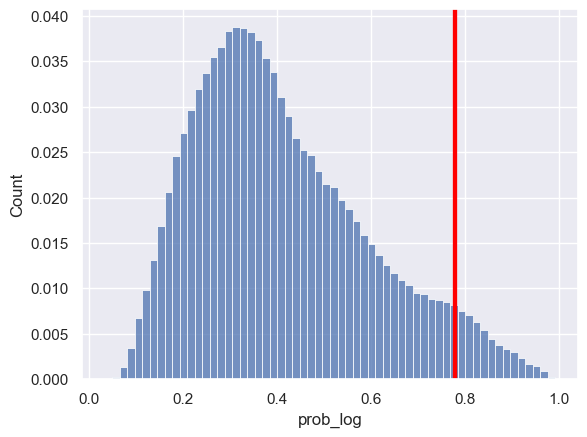

In [21]:
# ELECCION DE UMBRAL

# umbral_sup = 0.269
umbral_sup = 0.78
umbral_inf = 0
df1['umbral_sup'] = umbral_sup
df1['umbral_inf'] = umbral_inf

# RESULTADO PREVIO UMBRAL
sns.set_theme(style="darkgrid")
df2 = df1.explode('prob_log')
lw = 3.1
weights = np.ones_like(df2['prob_log']) / len(df2['prob_log'])
sns.histplot(x = df2['prob_log'], bins = 60, weights=weights)
# plt.axvline(x = umbral_inf, color='green', lw=lw)
plt.axvline(x = umbral_sup, color='red', lw=lw)
hist, bin_edges = np.histogram(df2['prob_log'], bins=60, weights=weights)
print(f"Aceptado: {hist[(bin_edges[:-1] >= 0) & (bin_edges[1:] < umbral_sup)].sum()/hist.sum()*100}")
# print(f"Revision: {hist[(bin_edges[:-1] >= umbral_inf) & (bin_edges[1:] <= umbral_sup)].sum()/hist.sum()*100}")
print(f"Denegado {hist[(bin_edges[:-1] >= umbral_sup) & (bin_edges[1:] <= 1)].sum()/hist.sum()*100}")
# plt.title('Principales causas de devolución', fontsize='large')

In [22]:
def umbral_scoring(dataframe,probabilidad,denegados,revision):
    umbral_sup = dataframe['umbral_sup']
    umbral_inf = dataframe['umbral_inf']
    prob = dataframe[probabilidad]
    def apply_umbral_sup(prob,umbral):
        if prob >= umbral:
            return 1
        else: 
            return 0
    def apply_umbral_inf(prob,umbral_inf,umbral_sup):
        if umbral_sup > prob >= umbral_inf:
            return 1
        else: 
            return 0
    dataframe[denegados] = dataframe.apply(lambda row: apply_umbral_sup(row[probabilidad],row['umbral_sup']), axis=1)
    dataframe[revision] = dataframe.apply(lambda row: apply_umbral_inf(row[probabilidad],row['umbral_inf'],row['umbral_sup']), axis=1)
    dataframe[dataframe['CANCELO_DeudaIntNok'] == 1][revision] == 1

def clasifica_estimacion(dataframe, real, estimacion, resultado):
    def apply_clf(row):
        if row[real] == 0 and row[estimacion] == 0:
            return 'Verdadero_negativo'
        elif row[real] < row[estimacion]:
            return 'Falso_positivo'
        elif row[real] > row[estimacion]:
            return 'Falso_negativo'
        elif row[real] == 1 and row[estimacion] == 1:
            return 'Verdadero_positivo'

    dataframe[resultado] = dataframe.apply(apply_clf, axis=1)

In [23]:
# umbral_scoring(df1,'prob_xgb','deudor_xgb','revision_xgb')
umbral_scoring(df1,'prob_log','deudor_log','revision_log')
# clasifica_estimacion(df1,'Deudor_real','deudor_xgb','Resultado_XGB')
clasifica_estimacion(df1,'Deudor_real','deudor_log','Resultado_LOG')

In [23]:
with pd.option_context('display.max_rows', 1, 'display.max_columns', None):
    display(df1[df1['Resultado_LOG'] == 'Verdadero_positivo'])

,TIPO_PAQ_FIBRA,id_order,Numero_DNI,id_client,provincia,cp,estado_solicitud,fecha_solicitud,fecha_validacion,canal,CANCELO_DeudaExtNok,CANCELO_DeudaIntNok,deuda,n_facturas,edad_client,nacionalidad,tipo_documento,port_movil,alta_movil,paq_movil,paq_fibra,paq_fijo,Paquete_Fibra,TIPO_PEDIDO,HUELLA_INTERMEDIO,HUELLA,deudor,prob_log,Deudor_real,Connection_Type,total_movil,Producto,Estimacion_impago_bruto,Estimacion_impago_log,umbral_sup,umbral_inf,deudor_log,revision_log,Resultado_LOG
86,0,18678272,Y5579746Y,9638569.0,Madrid,28982,Validated,2023-02-06 08:22:13,2023-02-07 16:03:44,04_TELEVENTA,0.0,0,1301,21.0,36.0,PERU,NIE,0,1,1,0,0,Not Specified,01_MOVIL,Alta_nueva,01_MOVIL_Alta_nueva,1,[0.8731046386894391],1,Movil,1,Alta nueva movil,50.111616,[43.752684712312],0.78,0,1,0,Verdadero_positivo


In [25]:
z = 0.891566891383268 - 0.0219863502472711 * 35 - 0.0664318525064357+ 0.491184968935014 + 0.154907416350783 + 0.260756953596602 + 0.895565244919071
1 / (1 + np.exp(-z))  

0.8650668555386236

In [26]:
df1[df1['revision_log'] == 1].estado_solicitud.value_counts(normalize=True)

estado_solicitud
Validated    0.999895
Delivered    0.000080
Cancelled    0.000025
Name: proportion, dtype: float64

# Visualizacion datos

Columnas bruto: 

    Sum Estimacion_impago     
    Nunique TP    
    Nunique FP    
    Nunique FN    
    
Columnas calculadas en base a las anteriores:

    Impago evitado filtrado por verdaderos positivos    
    Cancelaciones positivos / total ( TP / total )     
    Precision = TP / ( TP + FP )    
    Recall = TP / ( TP + FN )


In [42]:
df1.deudor_xgb.unique()

array([0, 1], dtype=int64)

## Metricas

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
targets = ['No deudor', 'Deudor']
print(classification_report(df1.Deudor_real, df1.deudor_log, 
                            target_names = targets,
                            digits = 6))

              precision    recall  f1-score   support

   No deudor   0.882819  0.987010  0.932011    862256
      Deudor   0.495995  0.088904  0.150781    123988

    accuracy                       0.874102    986244
   macro avg   0.689407  0.537957  0.541396    986244
weighted avg   0.834188  0.874102  0.833797    986244



Si hay diferencias con el total de las siguientes tablas es porque se hace el calculo con los id_client unicos, no a nivel nº filas

In [40]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(df1[(df1['Resultado_LOG'] == 'Verdadero_positivo') & (df1['prob_log'] > 0.55)])


,TIPO_PAQ_FIBRA,id_order,Numero_DNI,id_client,provincia,cp,estado_solicitud,fecha_solicitud,fecha_validacion,canal,CANCELO_DeudaExtNok,CANCELO_DeudaIntNok,deuda,n_facturas,edad_client,nacionalidad,tipo_documento,port_movil,alta_movil,paq_movil,paq_fibra,paq_fijo,Paquete_Fibra,TIPO_PEDIDO,HUELLA_INTERMEDIO,HUELLA,deudor,prob_log,Deudor_real,Connection_Type,total_movil,Producto,Estimacion_impago_bruto,Estimacion_impago_log,umbral_sup,umbral_inf,deudor_log,revision_log,Resultado_LOG
66,Fibra 1Gb,18678381,43137886Y,10378916.0,"Balears, Illes",7008,Validated,2023-02-06 08:30:50,2023-02-07 12:40:52,04_TELEVENTA,1.0,0,137,7.0,42.0,ESPAÑA,DNI,0,1,1,1,0,NEBA,02_MOV+FIBRA,Alta_nueva_+_Neba,02_MOV+FIBRA_Alta_nueva_+_Neba,1,[0.6773002160319468],1,Fibra_Neba,1,Alta nueva + fibra Neba,94.948405,[64.30857524558337],0.5,0.4,1,0,Verdadero_positivo
80,0,18678707,Y2276522L,9417585.0,Tarragona,43764,Validated,2023-02-06 08:53:43,2023-02-07 12:21:57,04_TELEVENTA,0.0,0,109,4.0,29.0,COLOMBIA,NIE,0,1,1,0,0,Not Specified,01_MOVIL,Alta_nueva,01_MOVIL_Alta_nueva,1,[0.697530561971856],1,Movil,1,Alta nueva movil,50.111616,[34.954383933827536],0.5,0.4,1,0,Verdadero_positivo
130,Fibra PRO-DIGI 10 Gb,18679310,X4865480Z,11230679.0,Madrid,28933,Validated,2023-02-06 09:25:10,2023-02-06 16:36:29,06_D2D,1.0,0,25,1.0,46.0,RUMANIA,NIE,0,0,0,1,0,PRO-DIGI,04_FIBRA,Propia,04_FIBRA_Propia,1,[0.7092242505489903],1,Fibra_Pro,0,Fibra Pro,70.285864,[49.84843914313768],0.5,0.4,1,0,Verdadero_positivo
268,Fibra PRO-DIGI 10 Gb,18680839,76924223X,11236133.0,Zaragoza,50003,Validated,2023-02-06 10:14:18,2023-02-07 15:27:22,04_TELEVENTA,1.0,0,394,10.0,36.0,ESPAÑA,DNI,1,0,1,1,0,PRO-DIGI,02_MOV+FIBRA,Portabilidad_+_Propia,02_MOV+FIBRA_Portabilidad_+_Propia,1,[0.5665890880849639],1,Fibra_Pro,1,Fibra Pro,70.285864,[39.82320352794852],0.5,0.4,1,0,Verdadero_positivo
964,Fibra 1Gb,18686842,31038307Z,11230517.0,Barcelona,8001,Validated,2023-02-06 12:16:56,2023-02-06 16:01:11,06_D2D,1.0,0,150,5.0,48.0,ESPAÑA,DNI,0,0,0,1,0,NEBA,04_FIBRA,Neba,04_FIBRA_Neba,1,[0.5944808383822985],1,Fibra_Neba,0,Fibra Neba,80.349845,[47.766443342142885],0.5,0.4,1,0,Verdadero_positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985611,Fibra SMART 1Gb,18662561,X5204604A,11234495.0,Valencia/València,46025,Validated,2023-02-05 13:39:42,2023-02-07 11:59:49,04_TELEVENTA,1.0,0,254,13.0,39.0,INDIA,NIE,0,0,0,1,0,SMART,04_FIBRA,Propia,04_FIBRA_Propia,1,[0.7718494650759483],1,Fibra_Smart,0,Fibra Smart,55.404120,[42.76364009385257],0.5,0.4,1,0,Verdadero_positivo
985784,0,18664804,46186087V,11233651.0,Madrid,28029,Validated,2023-02-05 16:19:22,2023-02-07 08:56:22,03_STAND,1.0,0,7,1.0,23.0,ESPAÑA,DNI,0,1,1,0,0,Not Specified,01_MOVIL,Alta_nueva,01_MOVIL_Alta_nueva,1,[0.7022963003375277],1,Movil,1,Alta nueva movil,50.111616,[35.19320278656847],0.5,0.4,1,0,Verdadero_positivo
985870,Fibra SMART 500Mb,18665999,06304291Z,11230729.0,Castellón/Castelló,12005,Validated,2023-02-05 17:33:04,2023-02-06 16:56:32,06_D2D,1.0,0,110,9.0,23.0,ESPAÑA,DNI,0,0,0,1,0,SMART,04_FIBRA,Propia,04_FIBRA_Propia,1,[0.7204847970963765],1,Fibra_Smart,0,Fibra Smart,55.404120,[39.9178258847276],0.5,0.4,1,0,Verdadero_positivo
986001,0,18668143,Y9939316H,9494001.0,Madrid,28029,Validated,2023-02-05 19:08:48,2023-02-07 08:48:26,04_TELEVENTA,0.0,0,43,2.0,32.0,PERU,NIE,0,1,1,0,0,Not Specified,01_MOVIL,Alta_nueva,01_MOVIL_Alta_nueva,1,[0.6187270042514614],1,Movil,1,Alta nueva movil,50.111616,[31.005410280080515],0.5,0.4,1,0,Verdadero_positivo


## Rdos logistica

In [27]:
resultados_prod_log = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].groupby('Producto').agg({'Estimacion_impago_bruto': ['sum'], 'id_client': ['nunique']}).rename(columns={'Estimacion_impago_bruto': 'Impago evitado', 'id_client': 'TP'})
resultados_prod_log['FP'] = df1[df1['Resultado_LOG'] == 'Falso_positivo'].groupby('Producto').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'FP'})
resultados_prod_log['FN'] = df1[df1['Resultado_LOG'] == 'Falso_negativo'].groupby('Producto').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'FN'})
resultados_prod_log['Validaciones'] = df1.groupby('Producto').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'Validaciones'})
resultados_prod_log.fillna(0, inplace=True)
resultados_prod_log = resultados_prod_log.reindex(orden_especifico_prod, axis=0)

resultados_prod_log.columns = resultados_prod_log.columns.droplevel(1)
resultados_prod_log['Cancelaciones'] = ( resultados_prod_log['TP'] + resultados_prod_log['FP'] ) / resultados_prod_log['Validaciones'] * 100
resultados_prod_log['Tasa de acierto (precision)'] = resultados_prod_log['TP'] / ( resultados_prod_log['TP'] + resultados_prod_log['FP'] ) * 100
resultados_prod_log['Tasa de identificación (recall)'] = resultados_prod_log['TP'] / ( resultados_prod_log['TP'] + resultados_prod_log['FN'] ) * 100
resultados_prod_log.rename(columns={"Estimacion_impago_log": "Impago evitado"}, inplace=True)

resultados_prod_log.loc['Total_prod'] = resultados_prod_log.sum(axis=0)
resultados_prod_log.loc['Total_prod','Cancelaciones'] = df1[df1['Resultado_LOG'].isin(['Verdadero_positivo','Falso_positivo'])].id_client.nunique() / df1.id_client.nunique() * 100
resultados_prod_log.loc['Total_prod','Tasa de acierto (precision)'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique() / (df1[df1['Resultado_LOG'] == 'Falso_positivo'].id_client.nunique() + df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique()) * 100
resultados_prod_log.loc['Total_prod','Tasa de identificación (recall)'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique() / (df1[df1['Resultado_LOG'] == 'Falso_negativo'].id_client.nunique() + df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique()) * 100

resultados_prod_log['Tasa F1'] = ( 2 * resultados_prod_log['Tasa de acierto (precision)'] * resultados_prod_log['Tasa de identificación (recall)'] ) / (resultados_prod_log['Tasa de acierto (precision)'] + resultados_prod_log['Tasa de identificación (recall)'] )

resultados_prod_log['Impago evitado'] = resultados_prod_log['Impago evitado'].apply(lambda x: "{:,.0f} €".format(x))
resultados_prod_log['Impago evitado'] = resultados_prod_log['Impago evitado'].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))

for c in ['Tasa de acierto (precision)','Tasa de identificación (recall)','Cancelaciones','Tasa F1']:

    resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: "{:,.2f} %".format(x))
    resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))

resultados_prod_log['id_client'] = resultados_prod_log['TP'] + resultados_prod_log['FP']

resultados_prod_log['FP'] = df1[df1['Resultado_LOG'] == 'Falso_positivo'].groupby('Producto').agg({'Numero_DNI': ['nunique']}).rename(columns={'Numero_DNI': 'FP'})
resultados_prod_log['TP'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].groupby('Producto').agg({'Numero_DNI': ['nunique']}).rename(columns={'Numero_DNI': 'TP'})

resultados_prod_log['Clientes unicos'] = resultados_prod_log['TP'] + resultados_prod_log['FP']
resultados_prod_log.loc['Total_prod','Clientes unicos'] = resultados_prod_log['Clientes unicos'].sum()

resultados_prod_log.drop(columns=['TP','FP','FN','Validaciones'], inplace=True)

for c in ['id_client','Clientes unicos']:
    resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: "{:,.0f}".format(x))
    resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))

print(umbral_sup)
resultados_prod_log

0.78


,Impago evitado,Cancelaciones,Tasa de acierto (precision),Tasa de identificación (recall),Tasa F1,id_client,Clientes unicos
Producto,,,,,,,
Alta nueva movil,1.053.146 €,"9,07 %","45,49 %","22,22 %","29,85 %",38.188,37.259
Portabilidad movil,13.030 €,"5,96 %","59,04 %","13,79 %","22,35 %",354,351
Alta nueva + fibra Smart,67.189 €,"4,78 %","66,79 %","9,97 %","17,35 %",1.400,1.395
Port + fibra Smart,27.861 €,"4,39 %","56,64 %","12,27 %","20,17 %",648,646
Fibra Smart,343.229 €,"2,60 %","50,72 %","12,10 %","19,54 %",11.713,11.264
Alta nueva + fibra Neba,69.502 €,"5,40 %","58,11 %","9,76 %","16,71 %",1.251,1.244
Port + fibra Neba,10.136 €,"2,22 %","55,77 %","6,34 %","11,38 %",208,207
Fibra Neba,202.964 €,"1,82 %","46,33 %","7,13 %","12,36 %",4.926,4.659
Alta nueva + fibra Pro,11.011 €,"4,72 %","71,20 %","8,14 %","14,62 %",191,191


In [28]:
resultados_canal_log = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].groupby('canal').agg({'Estimacion_impago_bruto': ['sum'], 'id_client': ['nunique']}).rename(columns={'Estimacion_impago_bruto': 'Impago evitado', 'id_client': 'TP'})
resultados_canal_log['FP'] = df1[df1['Resultado_LOG'] == 'Falso_positivo'].groupby('canal').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'FP'})
resultados_canal_log['FN'] = df1[df1['Resultado_LOG'] == 'Falso_negativo'].groupby('canal').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'FN'})
resultados_canal_log['Validaciones'] = df1.groupby('canal').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'Validaciones'})
resultados_canal_log.fillna(0, inplace=True)

resultados_canal_log.columns = resultados_canal_log.columns.droplevel(1)
resultados_canal_log['Cancelaciones'] = ( resultados_canal_log['TP'] + resultados_canal_log['FP'] ) / resultados_canal_log['Validaciones'] * 100
resultados_canal_log['Tasa de acierto (precision)'] = resultados_canal_log['TP'] / ( resultados_canal_log['TP'] + resultados_canal_log['FP'] ) * 100
resultados_canal_log['Tasa de identificación (recall)'] = resultados_canal_log['TP'] / ( resultados_canal_log['TP'] + resultados_canal_log['FN'] ) * 100
resultados_canal_log.rename(columns={"Estimacion_impago_log": "Impago evitado"}, inplace=True)

resultados_canal_log.loc['Total_canal'] = resultados_canal_log.sum(axis=0)
resultados_canal_log.loc['Total_canal','Cancelaciones'] = df1[df1['Resultado_LOG'].isin(['Verdadero_positivo','Falso_positivo'])].id_client.nunique() / df1.id_client.nunique() * 100
resultados_canal_log.loc['Total_canal','Tasa de acierto (precision)'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique() / (df1[df1['Resultado_LOG'] == 'Falso_positivo'].id_client.nunique() + df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique()) * 100
resultados_canal_log.loc['Total_canal','Tasa de identificación (recall)'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique() / (df1[df1['Resultado_LOG'] == 'Falso_negativo'].id_client.nunique() + df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique()) * 100

resultados_canal_log['Tasa F1'] = ( 2 * resultados_canal_log['Tasa de acierto (precision)'] * resultados_canal_log['Tasa de identificación (recall)'] ) / (resultados_canal_log['Tasa de acierto (precision)'] + resultados_canal_log['Tasa de identificación (recall)'] )

resultados_canal_log['Impago evitado'] = resultados_canal_log['Impago evitado'].apply(lambda x: "{:,.0f} €".format(x))
resultados_canal_log['Impago evitado'] = resultados_canal_log['Impago evitado'].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))

for c in ['Tasa de acierto (precision)','Tasa de identificación (recall)','Cancelaciones','Tasa F1']:

    resultados_canal_log[c] = resultados_canal_log[c].apply(lambda x: "{:,.2f} %".format(x))
    resultados_canal_log[c] = resultados_canal_log[c].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))

resultados_canal_log['id_client'] = resultados_canal_log['TP'] + resultados_canal_log['FP']

resultados_canal_log['FP'] = df1[df1['Resultado_LOG'] == 'Falso_positivo'].groupby('canal').agg({'Numero_DNI': ['nunique']}).rename(columns={'Numero_DNI': 'FP'})
resultados_canal_log['TP'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].groupby('canal').agg({'Numero_DNI': ['nunique']}).rename(columns={'Numero_DNI': 'TP'})

resultados_canal_log['Clientes unicos'] = resultados_canal_log['TP'] + resultados_canal_log['FP']
resultados_canal_log.loc['Total_canal','Clientes unicos'] = resultados_canal_log['Clientes unicos'].sum()

resultados_canal_log.drop(columns=['TP','FP','FN','Validaciones'], inplace=True)

for c in ['id_client','Clientes unicos']:
    resultados_canal_log[c] = resultados_canal_log[c].apply(lambda x: "{:,.0f}".format(x))
    resultados_canal_log[c] = resultados_canal_log[c].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))
    

resultados_canal_log

,Impago evitado,Cancelaciones,Tasa de acierto (precision),Tasa de identificación (recall),Tasa F1,id_client,Clientes unicos
canal,,,,,,,
01_DC,263.760 €,"3,53 %","41,69 %","11,39 %","17,89 %",9.766,9.395
02_WEB,482.086 €,"3,20 %","51,59 %","10,65 %","17,66 %",14.368,14.025
03_STAND,344.724 €,"6,21 %","44,75 %","20,10 %","27,74 %",11.994,11.673
04_TELEVENTA,237.708 €,"9,44 %","53,67 %","22,54 %","31,74 %",6.957,6.886
05_C2C,92.250 €,"2,32 %","49,67 %","10,11 %","16,80 %",3.068,3.030
06_D2D,446.259 €,"13,52 %","46,41 %","30,79 %","37,02 %",12.984,12.082
07_TIENDA_DIGI,1.416 €,"0,99 %","51,28 %","5,95 %","10,67 %",39,36
Total_canal,1.868.203 €,"4,82 %","46,66 %","15,37 %","23,12 %",59.176,57.127


In [25]:
def agrupar_producto_pre(producto):
    if producto in ['Alta nueva movil', 'Portabilidad movil']:
        return 'Movil'
    elif producto in ['Fibra Neba', 'Port + fibra Neba', 'Alta nueva + fibra Neba']:
        return 'Neba'
    else:
        return 'SMART'

df1['Producto_Agrupado'] = df1['Producto'].apply(agrupar_producto_pre)


In [26]:
resultados_prod_log = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].groupby('Producto_Agrupado').agg({'Estimacion_impago_bruto': ['sum'], 'id_client': ['nunique']}).rename(columns={'Estimacion_impago_bruto': 'Impago evitado', 'id_client': 'TP'})
resultados_prod_log['FP'] = df1[df1['Resultado_LOG'] == 'Falso_positivo'].groupby('Producto_Agrupado').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'FP'})
resultados_prod_log['FN'] = df1[df1['Resultado_LOG'] == 'Falso_negativo'].groupby('Producto_Agrupado').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'FN'})
resultados_prod_log['Validaciones'] = df1.groupby('Producto_Agrupado').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'Validaciones'})
resultados_prod_log.fillna(0, inplace=True)
resultados_prod_log = resultados_prod_log.reindex(['Movil','SMART','Neba'], axis=0)

resultados_prod_log.columns = resultados_prod_log.columns.droplevel(1)
resultados_prod_log['Cancelaciones'] = ( resultados_prod_log['TP'] + resultados_prod_log['FP'] ) / resultados_prod_log['Validaciones'] * 100
resultados_prod_log['Tasa de acierto (precision)'] = resultados_prod_log['TP'] / ( resultados_prod_log['TP'] + resultados_prod_log['FP'] ) * 100
resultados_prod_log['Tasa de identificación (recall)'] = resultados_prod_log['TP'] / ( resultados_prod_log['TP'] + resultados_prod_log['FN'] ) * 100
resultados_prod_log.rename(columns={"Estimacion_impago_log": "Impago evitado"}, inplace=True)

resultados_prod_log.loc['Total_prod'] = resultados_prod_log.sum(axis=0)
resultados_prod_log.loc['Total_prod','Cancelaciones'] = df1[df1['Resultado_LOG'].isin(['Verdadero_positivo','Falso_positivo'])].id_client.nunique() / df1.id_client.nunique() * 100
resultados_prod_log.loc['Total_prod','Tasa de acierto (precision)'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique() / (df1[df1['Resultado_LOG'] == 'Falso_positivo'].id_client.nunique() + df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique()) * 100
resultados_prod_log.loc['Total_prod','Tasa de identificación (recall)'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique() / (df1[df1['Resultado_LOG'] == 'Falso_negativo'].id_client.nunique() + df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique()) * 100

resultados_prod_log['Tasa F1'] = ( 2 * resultados_prod_log['Tasa de acierto (precision)'] * resultados_prod_log['Tasa de identificación (recall)'] ) / (resultados_prod_log['Tasa de acierto (precision)'] + resultados_prod_log['Tasa de identificación (recall)'] )

resultados_prod_log['Impago evitado'] = resultados_prod_log['Impago evitado'].apply(lambda x: "{:,.0f} €".format(x))
resultados_prod_log['Impago evitado'] = resultados_prod_log['Impago evitado'].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))

for c in ['Tasa de acierto (precision)','Tasa de identificación (recall)','Cancelaciones','Tasa F1']:

    resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: "{:,.2f} %".format(x))
    resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))

resultados_prod_log['id_client'] = resultados_prod_log['TP'] + resultados_prod_log['FP']

resultados_prod_log['FP'] = df1[df1['Resultado_LOG'] == 'Falso_positivo'].groupby('Producto_Agrupado').agg({'Numero_DNI': ['nunique']}).rename(columns={'Numero_DNI': 'FP'})
resultados_prod_log['TP'] = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].groupby('Producto_Agrupado').agg({'Numero_DNI': ['nunique']}).rename(columns={'Numero_DNI': 'TP'})

resultados_prod_log['Clientes unicos'] = resultados_prod_log['TP'] + resultados_prod_log['FP']
resultados_prod_log.loc['Total_prod','Clientes unicos'] = resultados_prod_log['Clientes unicos'].sum()

resultados_prod_log.drop(columns=['TP','FP','FN','Validaciones'], inplace=True)

for c in ['id_client','Clientes unicos']:
    resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: "{:,.0f}".format(x))
    resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))

resultados_prod_log

,Impago evitado,Cancelaciones,Tasa de acierto (precision),Tasa de identificación (recall),Tasa F1,id_client,Clientes unicos
Producto_Agrupado,,,,,,,
Movil,1.066.176 €,"9,03 %","45,58 %","22,09 %","29,75 %",38.446,37.499
SMART,519.426 €,"2,84 %","52,89 %","11,74 %","19,21 %",15.495,14.905
Neba,282.602 €,"2,07 %","48,54 %","7,52 %","13,03 %",6.230,5.918
Total_prod,1.868.203 €,"4,82 %","46,66 %","15,37 %","23,12 %",60.171,58.322


In [27]:
for productillo in ['SMART','Neba']:  #'Movil',
    df2 = df1[df1['Producto_Agrupado']==productillo]
    resultados_prod_log = df2[df2['Resultado_LOG'] == 'Verdadero_positivo'].groupby('canal').agg({'Estimacion_impago_bruto': ['sum'], 'id_client': ['nunique']}).rename(columns={'Estimacion_impago_bruto': 'Impago evitado', 'id_client': 'TP'})
    resultados_prod_log['FP'] = df2[df2['Resultado_LOG'] == 'Falso_positivo'].groupby('canal').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'FP'})
    resultados_prod_log['FN'] = df2[df2['Resultado_LOG'] == 'Falso_negativo'].groupby('canal').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'FN'})
    resultados_prod_log['Validaciones'] = df2.groupby('canal').agg({'id_client': ['nunique']}).rename(columns={'id_client': 'Validaciones'})
    resultados_prod_log.fillna(0, inplace=True)
    
    resultados_prod_log.columns = resultados_prod_log.columns.droplevel(1)
    resultados_prod_log['Cancelaciones'] = ( resultados_prod_log['TP'] + resultados_prod_log['FP'] ) / resultados_prod_log['Validaciones'] * 100
    resultados_prod_log['Tasa de acierto (precision)'] = resultados_prod_log['TP'] / ( resultados_prod_log['TP'] + resultados_prod_log['FP'] ) * 100
    resultados_prod_log['Tasa de identificación (recall)'] = resultados_prod_log['TP'] / ( resultados_prod_log['TP'] + resultados_prod_log['FN'] ) * 100
    resultados_prod_log.rename(columns={"Estimacion_impago_log": "Impago evitado"}, inplace=True)
    
    resultados_prod_log.loc['Total_prod'] = resultados_prod_log.sum(axis=0)
    resultados_prod_log.loc['Total_prod','Cancelaciones'] = df2[df2['Resultado_LOG'].isin(['Verdadero_positivo','Falso_positivo'])].id_client.nunique() / df2.id_client.nunique() * 100
    resultados_prod_log.loc['Total_prod','Tasa de acierto (precision)'] = df2[df2['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique() / (df2[df2['Resultado_LOG'] == 'Falso_positivo'].id_client.nunique() + df2[df2['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique()) * 100
    resultados_prod_log.loc['Total_prod','Tasa de identificación (recall)'] = df2[df2['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique() / (df2[df2['Resultado_LOG'] == 'Falso_negativo'].id_client.nunique() + df2[df2['Resultado_LOG'] == 'Verdadero_positivo'].id_client.nunique()) * 100
    
    resultados_prod_log['Tasa F1'] = ( 2 * resultados_prod_log['Tasa de acierto (precision)'] * resultados_prod_log['Tasa de identificación (recall)'] ) / (resultados_prod_log['Tasa de acierto (precision)'] + resultados_prod_log['Tasa de identificación (recall)'] )
    
    resultados_prod_log['Impago evitado'] = resultados_prod_log['Impago evitado'].apply(lambda x: "{:,.0f} €".format(x))
    resultados_prod_log['Impago evitado'] = resultados_prod_log['Impago evitado'].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))
    
    for c in ['Tasa de acierto (precision)','Tasa de identificación (recall)','Cancelaciones','Tasa F1']:
    
        resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: "{:,.2f} %".format(x))
        resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))
    
    resultados_prod_log['id_client'] = resultados_prod_log['TP'] + resultados_prod_log['FP']
    
    resultados_prod_log['FP'] = df2[df2['Resultado_LOG'] == 'Falso_positivo'].groupby('canal').agg({'Numero_DNI': ['nunique']}).rename(columns={'Numero_DNI': 'FP'})
    resultados_prod_log['TP'] = df2[df2['Resultado_LOG'] == 'Verdadero_positivo'].groupby('canal').agg({'Numero_DNI': ['nunique']}).rename(columns={'Numero_DNI': 'TP'})
    
    resultados_prod_log['Clientes unicos'] = resultados_prod_log['TP'] + resultados_prod_log['FP']
    resultados_prod_log.loc['Total_prod','Clientes unicos'] = resultados_prod_log['Clientes unicos'].sum()
    
    resultados_prod_log.drop(columns=['TP','FP','FN','Validaciones'], inplace=True)
    
    for c in ['id_client','Clientes unicos']:
        resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: "{:,.0f}".format(x))
        resultados_prod_log[c] = resultados_prod_log[c].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))
    
    print(productillo)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(resultados_prod_log)

SMART


,Impago evitado,Cancelaciones,Tasa de acierto (precision),Tasa de identificación (recall),Tasa F1,id_client,Clientes unicos
canal,,,,,,,
01_DC,58.764 €,"2,04 %","48,93 %","8,53 %","14,52 %",1.958,1.890
02_WEB,97.640 €,"1,44 %","58,42 %","6,83 %","12,23 %",2.643,2.602
03_STAND,51.061 €,"1,83 %","48,57 %","8,10 %","13,89 %",1.711,1.673
04_TELEVENTA,59.999 €,"4,61 %","64,88 %","15,32 %","24,79 %",1.475,1.456
05_C2C,37.779 €,"1,75 %","51,38 %","9,19 %","15,60 %",1.199,1.188
06_D2D,213.909 €,"8,95 %","51,13 %","24,38 %","33,02 %",6.698,6.389
07_TIENDA_DIGI,273 €,"0,62 %","33,33 %","3,01 %","5,52 %",12,10
Total_prod,519.426 €,"2,84 %","52,89 %","11,74 %","19,21 %",15.696,15.208


Neba


,Impago evitado,Cancelaciones,Tasa de acierto (precision),Tasa de identificación (recall),Tasa F1,id_client,Clientes unicos
canal,,,,,,,
01_DC,35.925 €,"1,21 %","44,19 %","4,26 %","7,78 %",869,795
02_WEB,41.669 €,"0,67 %","60,54 %","2,93 %","5,59 %",783,771
03_STAND,53.165 €,"2,90 %","49,53 %","12,97 %","20,55 %",1.165,1.127
04_TELEVENTA,60.105 €,"5,38 %","55,16 %","13,62 %","21,85 %",1.249,1.244
05_C2C,13.795 €,"0,74 %","47,84 %","3,30 %","6,18 %",324,321
06_D2D,77.702 €,"15,08 %","42,61 %","31,83 %","36,44 %",1.976,1.846
07_TIENDA_DIGI,241 €,"0,47 %","75,00 %","4,92 %","9,23 %",4,3
Total_prod,282.602 €,"2,07 %","48,54 %","7,52 %","13,03 %",6.370,6.107


## Costes

In [666]:
funciones.estimacion_costes(df1)

In [677]:
resultados_canal_log = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].groupby('canal').agg({'Coste': ['sum']})
resultados_canal_log.columns = resultados_canal_log.columns.droplevel(1)
resultados_canal_log['Coste'] = resultados_canal_log['Coste'].apply(lambda x: "{:,.0f} €".format(x))
resultados_canal_log['Coste'] = resultados_canal_log['Coste'].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))
resultados_canal_log

,Coste
canal,
01_DC,81.105 €
02_WEB,211.884 €
03_STAND,70.627 €
04_TELEVENTA,129.894 €
05_C2C,51.547 €
06_D2D,201.142 €
07_TIENDA_DIGI,333 €


In [678]:
resultados_prod_log = df1[df1['Resultado_LOG'] == 'Verdadero_positivo'].groupby('Producto').agg({'Coste': ['sum']})
resultados_prod_log = resultados_prod_log.reindex(orden_especifico_prod, axis=0)
resultados_prod_log.columns = resultados_prod_log.columns.droplevel(1)
resultados_prod_log['Coste'] = resultados_prod_log['Coste'].apply(lambda x: "{:,.0f} €".format(x))
resultados_prod_log['Coste'] = resultados_prod_log['Coste'].apply(lambda x: x.replace(',', '&').replace('.', ',').replace('&', '.'))
resultados_prod_log

,Coste
Producto,
Alta nueva movil,81.142 €
Portabilidad movil,568 €
Alta nueva + fibra Smart,40.186 €
Port + fibra Smart,14.159 €
Fibra Smart,258.593 €
Alta nueva + fibra Neba,140.671 €
Port + fibra Neba,3.703 €
Fibra Neba,95.808 €
Alta nueva + fibra Pro,12.924 €


In [669]:
df1[(df1['Resultado_LOG'].isin(['Verdadero_positivo','Falso_positivo']))].id_client.nunique()

52128

In [670]:
df1.id_client.nunique()

1161010

In [671]:
df1[(df1['CANCELO_DeudaIntNok'] == 1) & (df1['Resultado_LOG'].isin(['Verdadero_negativo','Falso_negativo']))].id_client.nunique()

34

# Exportar coeficientes

In [44]:
coef_df = pd.DataFrame(list(zip(X.columns, log.coef_.flatten())), columns=['Feature', 'Coeficiente'])
intercepto = log.intercept_


coef_df = coef_df.transpose()

# Cambiar el indice de la tabla por la fila que contiene el nombre de las columnas del df_test
coef_df.columns = coef_df.iloc[0]
coef_df = coef_df[1:]

coef_df = coef_df.transpose()

new_row = pd.DataFrame({'Coeficiente': [intercepto[0]]}, index=['Intercepto'])
coef_df = pd.concat([new_row, coef_df]).reset_index().rename(columns={"index": "Feature"})

for i in range(len((coef_df))):
    if coef_df['Feature'].iloc[i] == '02_MOV+FIBRA_Alta_nueva_+_Propia':             #Alta nueva y fibra smart
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_coeficientepositivo
        
    elif coef_df['Feature'].iloc[i] == '02_MOV+FIBRA_Portabilidad_+_Propia':          #Porta y fibra smart
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_coeficientenegativo
        
    elif coef_df['Feature'].iloc[i] == '03_MOV+FIJO+FIBRA_Alta_nueva_+_Propia':      #Alta nueva y fibra smart
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_coeficientepositivo

    elif coef_df['Feature'].iloc[i] == '03_MOV+FIJO+FIBRA_Portabilidad_+_Propia':      #Porta y fibra smart
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_coeficientenegativo

    elif coef_df['Feature'].iloc[i] == '04_FIBRA_Propia':                               #Fibra smart
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_coeficientenegativo

    elif coef_df['Feature'].iloc[i] == '05_FIBRA+FIJO_Propia':                        #Fibra smart
        coef_df['Coeficiente'].iloc[i] = coef_df['Coeficiente'].iloc[i] * factor_coeficientenegativo

coef_df

,Feature,Coeficiente
0,Intercepto,0.891567
1,CANCELO_DeudaExtNok,1.897984
2,CANCELO_DeudaIntNok,1.720186
3,edad_client,-0.021986
4,01_DC,-0.066432
...,...,...
100,03_MOV+FIJO+FIBRA_Portabilidad_+_Propia,-1.04376
101,04_FIBRA_Neba,-0.094124
102,04_FIBRA_Propia,-0.298641
103,05_FIBRA+FIJO_Neba,-0.021127


In [26]:
intercepto = log.intercept_
intercepto

array([0.64801076])

In [24]:
coef_df.to_excel('coeficientes_actualizados_log.xlsx')